In [10]:
import os
os.environ["SPARK_HOME"] = "/home/anyes/spark"
os.environ["JAVA_HOME"] = "/usr"

In [11]:
# Main imports
import findspark
from pyspark.sql import SparkSession
from pyspark import SparkConf

# for dataframe and udf
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.types import *
from datetime import *

import pandas as pd


# initialise environment variables for spark
findspark.init()

# Start spark session
# --------------------------
def start_spark():
  local = "local[*]"
  appName = "PLDAC"

  gf = "graphframes:graphframes:0.8.3-spark3.5-s_2.12"

  configLocale = SparkConf().setAppName(appName).setMaster(local).\
  set("spark.executor.memory", "6G").\
  set("spark.driver.memory","6G").\
  set("spark.sql.catalogImplementation","in-memory").\
  set("spark.jars.packages", gf)

  spark = SparkSession.builder.config(conf = configLocale).getOrCreate()
  sc = spark.sparkContext
  sc.setLogLevel("ERROR")

  spark.conf.set("spark.sql.autoBroadcastJoinThreshold","-1")

  # Adjust the query execution environment to the size of the cluster (4 cores)
  spark.conf.set("spark.sql.shuffle.partitions","4")
  print("session started, its id is ", sc.applicationId)
  return spark
#spark = start_spark()

In [12]:
#Import GraphFrames
from graphframes import GraphFrame
from graphframes.lib import AggregateMessages as AM
from graphframes.lib import Pregel

#For connectedComponents()
# !pwd
# !mkdir /content/checkpoints
spark.sparkContext.setCheckpointDir('./content/checkpoints')

# Exemple d'utilisation de node2vec

## Importation des bibliotheques

In [1]:
import networkx as nx
import random
import string
from node2vec import Node2Vec
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier

/home/anyes/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [32]:
# import networkx as nx
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score

# # Créer un graphe de test
# G = nx.karate_club_graph()

# # Effectuer l'apprentissage de Node2Vec
# from node2vec import Node2Vec

# node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)  
# model = node2vec.fit(window=10, min_count=1, batch_words=4)  

# # Obtenez les vecteurs de nœuds appris
# node_embeddings = model.wv

# # Créer un vecteur de caractéristiques pour chaque nœud
# X = np.array([node_embeddings[str(node)] for node in range(len(G))])

# # Créer les étiquettes de classification pour chaque nœud (par exemple, club)
# labels = [1 if G.nodes[node]['club'] == 'Mr. Hi' else 0 for node in G.nodes()]

# # Diviser les données en ensembles d'entraînement et de test
# X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# # Entraîner un classifieur (par exemple, Régression logistique)
# classifier = LogisticRegression()
# classifier.fit(X_train, y_train)

# # Prédire les étiquettes pour les données de test
# y_pred = classifier.predict(X_test)

# # Calculer l'exactitude
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)


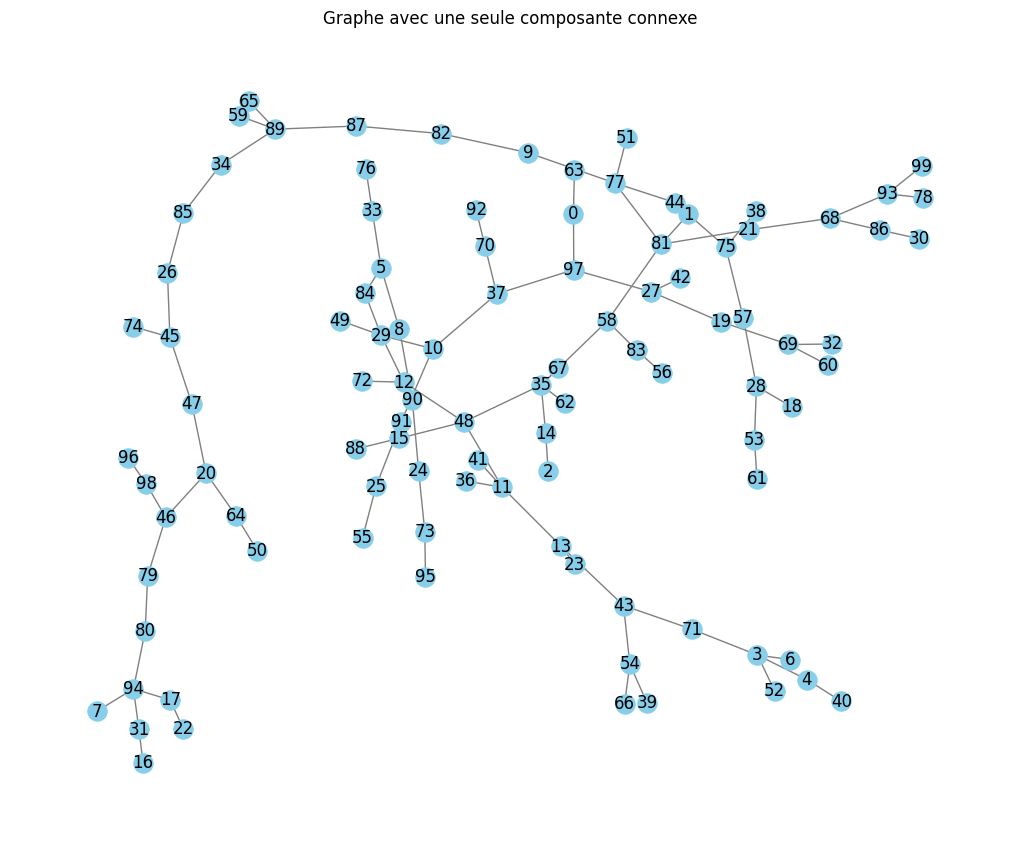

In [2]:


# Fixer la seed aléatoire pour la reproductibilité
random.seed(42)

# Nombre de nœuds souhaité
num_nodes = 100

# Création d'un arbre aléatoire avec num_nodes nœuds
G = nx.random_tree(num_nodes)

# Ajout d'arêtes supplémentaires pour créer une seule composante connexe
while not nx.is_connected(G):
    # Sélection aléatoire de deux nœuds
    src = random.choice(list(G.nodes))
    dst = random.choice(list(G.nodes))
    # Vérifier que les nœuds sélectionnés sont différents et qu'il n'y a pas déjà d'arête entre eux
    if src != dst and not G.has_edge(src, dst):
        # Ajouter l'arête
        G.add_edge(src, dst)

# Définir la disposition des nœuds pour un tracé plus esthétique
pos = nx.spring_layout(G)

# Tracer le graphe
plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, node_size=200, node_color='skyblue', edge_color='gray', linewidths=0.5)
plt.title("Graphe avec une seule composante connexe")
plt.show()




In [3]:
# Génération des étiquettes pour 70% des nœuds
num_labeled_nodes = int(0.7 * num_nodes)
labeled_nodes = random.sample(list(G.nodes), num_labeled_nodes)

# Génération aléatoire des étiquettes pour chaque nœud
labels = {}
for node in labeled_nodes:
    num_labels = random.randint(1, 10)  # Nombre aléatoire d'étiquettes pour chaque nœud (entre 1 et 10)
    node_labels = []
    for _ in range(num_labels):
        label = str(random.randint(1, 50))  # Génération d'une étiquette aléatoire entre "1" et "50"
        node_labels.append(label)
    labels[node] = node_labels
# Affichage des étiquettes
for node, node_labels in labels.items():
    print(f"Noeud {node}: {node_labels}")

Noeud 31: ['33', '7', '41']
Noeud 20: ['41', '33', '39', '13', '10']
Noeud 59: ['49', '11', '35', '50', '34', '1']
Noeud 48: ['21', '32', '2', '8', '24', '20', '16', '4', '16', '37']
Noeud 34: ['6', '47']
Noeud 81: ['5', '49', '35', '50', '9', '9', '43', '31']
Noeud 88: ['11', '17', '34', '39', '28', '14', '35', '49', '47']
Noeud 71: ['46', '20', '26', '43']
Noeud 28: ['29', '34', '29', '8', '16', '15']
Noeud 87: ['22', '2']
Noeud 41: ['36', '15', '38', '15', '1', '5', '46', '41', '4', '15']
Noeud 7: ['3', '22']
Noeud 29: ['33', '16']
Noeud 4: ['43', '32', '14', '35', '9']
Noeud 40: ['37', '31', '16', '31', '27', '13', '7', '7', '43', '28']
Noeud 51: ['28', '27', '30', '47', '4', '44']
Noeud 95: ['4', '26']
Noeud 8: ['7', '16', '13', '13', '35', '29']
Noeud 27: ['28', '12', '18']
Noeud 72: ['16', '5', '29', '36', '7', '4', '42', '35']
Noeud 85: ['6']
Noeud 94: ['11', '27', '32', '31']
Noeud 63: ['26', '4', '11', '25']
Noeud 50: ['25']
Noeud 58: ['30', '19', '28', '45', '47']
Noeud 18: 

In [4]:
# Convertir les étiquettes en vecteurs One-Hot Encoding
all_labels = set(label for node_labels in labels.values() for label in node_labels)
print("all_labels ",all_labels)
label_index_map = {label: i for i, label in enumerate(all_labels)}
total_label_count = len(all_labels)
one_hot_labels = {}
for node, node_labels in labels.items():
    one_hot_label = [0] * total_label_count
    for label in node_labels:
        one_hot_label[label_index_map[label]] = 1
    one_hot_labels[node] = one_hot_label

print("one_hot_labels ", one_hot_labels)

all_labels  {'14', '10', '8', '34', '31', '12', '49', '6', '47', '19', '33', '3', '23', '7', '46', '41', '22', '38', '50', '13', '28', '18', '32', '24', '45', '48', '1', '9', '42', '40', '39', '21', '43', '17', '44', '30', '16', '26', '11', '36', '15', '5', '35', '4', '20', '27', '25', '2', '29', '37'}
one_hot_labels  {31: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 20: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 59: [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], 48: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1], 34: [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,

## Classification

In [6]:
# Générer les embeddings de noeuds avec Node2Vec
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Obtenir les embeddings de noeuds appris
node_embeddings = model.wv


# Créer les caractéristiques X et les étiquettes y pour la classification
X = np.array([node_embeddings.get_vector(str(node)) for node in labeled_nodes])
y = np.array([one_hot_labels.get(node, [0] * total_label_count) for node in labeled_nodes])

print(X.shape , y.shape)
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




Computing transition probabilities: 100%|██████████| 100/100 [00:00<00:00, 6125.22it/s]


Generating walks (CPU: 2): 100%|██████████| 50/50 [00:03<00:00, 16.33it/s]


(70, 64) (70, 50)
Accuracy: 0.0


/home/anyes/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [17]:
# Création du classificateur MLPClassifier
#classifier = MLPClassifier( alpha=1e-5, hidden_layer_sizes=(100,), max_iter=100, activation='relu', solver='adam', random_state=42)
classifier = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15,), random_state=1) 
classifier.fit(X_train, y_train)

# Prédire les étiquettes pour les données de test
y_pred = classifier.predict(X_test)

# Calculer l'exactitude
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.0


/home/anyes/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [26]:
y_pred_train = classifier.predict(X_train)

# Calculer l'exactitude
accuracy = accuracy_score(y_train, y_pred_train)
print("Accuracy:", accuracy)

Accuracy: 0.35714285714285715


## Clustering

In [70]:
import hdbscan

# # Générer les embeddings de nœuds avec Node2Vec
# node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
# model = node2vec.fit(window=10, min_count=1, batch_words=4)

# # Obtenir les embeddings de nœuds appris
# node_embeddings = model.wv

# Appliquer HDBSCAN sur les embeddings de nœuds
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=5)  # Spécifiez les paramètres appropriés
clusters = clusterer.fit_predict(node_embeddings.vectors)

# Afficher les clusters pour les 10 premiers nœuds
for node, cluster in zip(node_embeddings.index_to_key[:10], clusters[:10]):
    print(f"Noeud {node} : Cluster {cluster}")

Noeud 35 : Cluster 0
Noeud 3 : Cluster 0
Noeud 94 : Cluster 0
Noeud 89 : Cluster 0
Noeud 77 : Cluster 0
Noeud 48 : Cluster 0
Noeud 29 : Cluster 1
Noeud 11 : Cluster 0
Noeud 81 : Cluster 0
Noeud 69 : Cluster -1


### Grid search

In [71]:
import hdbscan
from sklearn.metrics import silhouette_score, make_scorer
from sklearn.model_selection import GridSearchCV

# Définir une fonction de score personnalisée utilisant silhouette_score
def hdbscan_silhouette_score(estimator, X):
    labels = estimator.fit_predict(X)
    try:
        score = silhouette_score(X, labels)
    except ValueError:
        score = -1  # Si silhouette_score ne peut pas être calculé
    return score

# Paramètres à rechercher
param_grid = {
    'min_cluster_size': [3, 5, 10],
    'min_samples': [3, 5, 10]
}

# Création de l'objet HDBSCAN
clusterer = hdbscan.HDBSCAN()

# Création de l'objet GridSearchCV avec la fonction de score personnalisée
grid_search = GridSearchCV(clusterer, param_grid, cv=5, scoring=make_scorer(hdbscan_silhouette_score))

# Exécution de la recherche sur la grille
grid_search.fit(node_embeddings.vectors)

# Affichage des meilleurs paramètres
print("Meilleurs paramètres trouvés :", grid_search.best_params_)

# Obtention des clusters avec les meilleurs paramètres
best_clusterer = hdbscan.HDBSCAN(**grid_search.best_params_)
best_clusters = best_clusterer.fit_predict(node_embeddings.vectors)

# Affichage des clusters pour les 10 premiers nœuds
for node, cluster in zip(node_embeddings.index_to_key[:10], best_clusters[:10]):
    print(f"Noeud {node} : Cluster {cluster}")



/home/anyes/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/anyes/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/home/anyes/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/anyes/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/home/anyes/.local/lib

Meilleurs paramètres trouvés : {'min_cluster_size': 3, 'min_samples': 3}
Noeud 35 : Cluster 4
Noeud 3 : Cluster 1
Noeud 94 : Cluster 0
Noeud 89 : Cluster 3
Noeud 77 : Cluster 6
Noeud 48 : Cluster -1
Noeud 29 : Cluster 2
Noeud 11 : Cluster 1
Noeud 81 : Cluster 5
Noeud 69 : Cluster 2


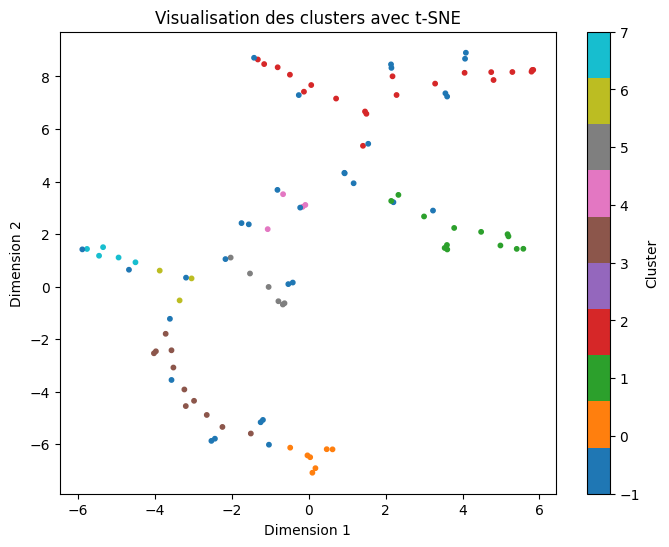

In [72]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Réduction de dimensionnalité avec t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(node_embeddings.vectors)

# Affichage des clusters avec un graphique de dispersion
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=best_clusters, cmap='tab10', s=10)
plt.colorbar(label='Cluster')
plt.title('Visualisation des clusters avec t-SNE')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

# GNN

In [75]:
import dgl
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier

# Définir un modèle de GNN simple avec une couche de convolution de graphe
class GNN(nn.Module):
    def __init__(self, in_feats, hidden_size, out_feats):
        super(GNN, self).__init__()
        self.conv1 = dgl.nn.GraphConv(in_feats, hidden_size)
        self.conv2 = dgl.nn.GraphConv(hidden_size, out_feats)

    def forward(self, g, features):
        x = torch.relu(self.conv1(g, features))
        x = torch.relu(self.conv2(g, x))
        return x

# Convertir le graphe en un objet DGLGraph
g_dgl = dgl.from_networkx(G)

# Créer le modèle GNN
model = GNN(node_embeddings.shape[1], 64, len(np.unique(y)))

# Convertir les données en tenseurs PyTorch
X_tensor = torch.FloatTensor(X)
y_tensor = torch.LongTensor(np.argmax(y, axis=1))
clusterer
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Définir la fonction de perte et l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Entraîner le modèle
model.train()
for epoch in range(100):
    optimizer.zero_grad()
    logits = model(g_dgl, X_train)
    loss = criterion(logits, y_train)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Évaluation du modèle
model.eval()
logits = model(g_dgl, X_test)
y_pred = torch.argmax(logits, dim=1)
accuracy = accuracy_score(y_test.numpy(), y_pred.numpy())
print("Accuracy:", accuracy)


FileNotFoundError: Cannot find DGL C++ graphbolt library at /home/anyes/.local/lib/python3.8/site-packages/dgl/graphbolt/libgraphbolt_pytorch_2.2.2.so

lire sur GNN , chercher exemple
graph vite
comprendre comment fonctionne node2vec